,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-0.717427,-1.091046,-0.373655,-0.585110,-0.522842,-0.710421,-1.031876,-0.968299,0
1,-1.029213,0.466314,-2.456964,0.557421,0.100631,1.426730,5.115111,0.209585,1
2,-0.093854,-1.447941,-1.655691,0.271788,-0.573394,-0.297238,-0.797126,-0.477514,1
3,-0.405640,2.413014,-0.053146,1.509530,3.260122,-0.368477,-1.057960,2.172726,1
4,-0.717427,2.153454,-0.854419,-0.585110,5.812990,-0.425468,-0.362402,2.761668,1


Working on: CPU
Loading: 10.0% Mean 0.53 CI: 0.48 0.59 Epsilon: 0.94
Loading: 20.0% Mean 0.55 CI: 0.5 0.61 Epsilon: 0.69
Loading: 30.0% Mean 0.59 CI: 0.53 0.64 Epsilon: 0.5
Loading: 40.0% Mean 0.59 CI: 0.54 0.65 Epsilon: 0.37
Loading: 50.0% Mean 0.59 CI: 0.53 0.64 Epsilon: 0.27
Loading: 60.0% Mean 0.63 CI: 0.57 0.68 Epsilon: 0.2
Loading: 70.0% Mean 0.66 CI: 0.61 0.71 Epsilon: 0.14
Loading: 80.0% Mean 0.66 CI: 0.61 0.71 Epsilon: 0.1
Loading: 90.0% Mean 0.66 CI: 0.61 0.71 Epsilon: 0.08
Loading: 100.0% Mean 0.65 CI: 0.59 0.7 Epsilon: 0.06
Loading: 108.0% Mean 0.66 CI: 0.6 0.71 Epsilon: 0.04
Working on: CPU

Eval
 Mean 0.68 CI: 0.58 0.78  


<Axes: title={'center': 'Training Accuracy'}, xlabel='Rounds', ylabel='Accuracy'>

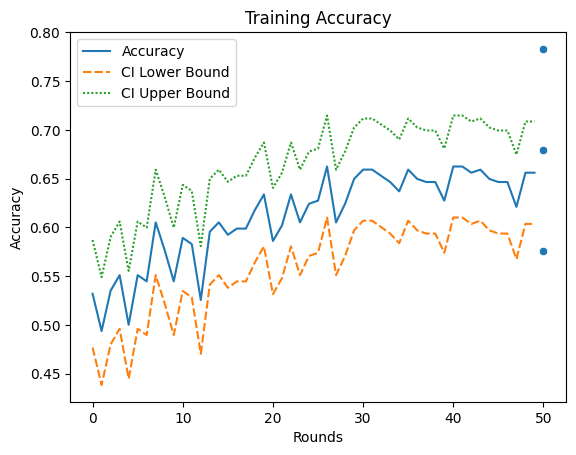

In [172]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import os
import seaborn as sns
import random
import torch.cuda
from matplotlib import pyplot as plt
import pickle

df = pd.read_csv('diabetes_transformed.csv')

display(df.head())

inp = df.values
ratio = 0.8 # % af data der bruges til træning, resten validering
split_mark = int(np.ceil(len(inp)*ratio))

X= inp[:split_mark]
Y = inp[split_mark:]


class Linear_QNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.linear1 = nn.Linear(8, 256)
        self.linear2 = nn.Linear(256,512)
        self.linear3 = nn.Linear(512, 256)
        self.linear4 = nn.Linear(256,2)
        
    def forward(self, x):
        x = F.tanh(self.linear1(x))
        x = F.tanh(self.linear2(x))
        x = F.tanh(self.linear3(x))
        x = F.tanh(self.linear4(x))
        return x
    
    def save(self, file_name='model.pth', index=0):
        model_folder_path = './DQN_models/model' 
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        complete_file_name = f"{index}_{file_name}"
        file_path = os.path.join(model_folder_path, complete_file_name)
        
        torch.save(self.state_dict(), file_path)
    
class QTrainer:
    def __init__(self, model, lr, gamma):
        self.lr = lr
        self.gamma = gamma
        self.model = model
        self.device = model.device
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    def train_step(self, state, action, reward, done, outcome):
        state = torch.tensor(np.array(state), dtype=torch.float).to(self.device)
        action = torch.tensor(np.array(action), dtype=torch.long).to(self.device)
        reward = torch.tensor(np.array(reward), dtype=torch.float).to(self.device)
        # (n, x)

        if len(state.shape) == 1:
            # (1, x)
            state = torch.unsqueeze(state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done, )

        # 1: predicted Q values with current state
        pred = self.model(state)
        target = pred.clone()
        if list(outcome) == 1:
            target[0,0] = 1
            target[0,1] = 0
        else:
            target[0,0] = 0
            target[0,1] = 1

        # target = torch.tensor([1,0] if list(outcome) == 1 else [0,1])
        # target = target_model(state)

        ## If we have more than one state-action pair to train on, do so in a loop.
        ## If not, we will only process one pair

        # for idx in range(len(done)):
        #     Q_new = reward[idx]
        #     target[idx][torch.argmax(action[idx]).item()] = Q_new
    
        # 2: Q_new = r + y * max(next_predicted Q value) -> only do this if not done
        # pred.clone()
        # preds[argmax(action)] = Q_new
        self.optimizer.zero_grad()

        ## Calculate MSE loss on target and prediction
        loss = self.criterion(target, pred)
        loss.backward()

        self.optimizer.step()


# eps decay 0.9998, LR 0.001 VIRKER

## Agent tager filepath som input hvis man vil køre en model, der allerede er trænet.
class Agent:
    def __init__(self, file_path=None, training=True, device=None, epsilon_decay=0.99999, 
                 learning_rate=0.01, model_name='testing', epsilon_min=0.01, gamma=0.9, epsilon=1, data=None):
        self.data = data
        self.MAX_MEMORY = 5_000 ## Længde af buffer
        self.BATCH_SIZE = 32 ## Sample størrelse
        self.LR = learning_rate ## Learning rate (TIDLIGERE 0.01 for onestep)
        if device is not None: ## Her kan man vælge at køre cpu selvom man har cuda
            self.device = device
        else:
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("Working on:", f"{self.device}".upper())
        self.epsilon = epsilon if training else 0  ## Tilfældighed
        self.gamma = gamma  ## Discount faktor
        self.memory = deque(maxlen=self.MAX_MEMORY)  ## popleft() buffer
        self.model_name = model_name

        ## Definerer en masse variable baseret på __init__ input
        self.is_training = training

        self.model = Linear_QNet().to(self.device) 

        self.file_path = file_path

        ## Hvis vi har en sti til en model, vil vi loade den i stedet for at træne en ny
        if self.file_path is not None:
            self.model.load_state_dict(torch.load(self.file_path, map_location=self.device))
            self.model.eval()

        ## Initialisér trainer
        self.trainer = QTrainer(self.model, lr=self.LR, gamma=self.gamma)

        ## Vores epsilon behøver ikke at være så stor for onestep, da repræsentationen af staten er så simpel.
        ## Den skal være højere for vector og grid repræsentation
        self.epsilon_decay = epsilon_decay  #0.9995 if state_rep=='onestep' else 0.999998  # Decaying rate per game
        self.epsilon_min = epsilon_min ## Minimumsværdi af epsilon


        ## Gemmer state-actionpar til buffer
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

        ## Træner long memory
    def train_long_memory(self):
        if len(self.memory) > self.BATCH_SIZE:
            mini_sample = random.sample(self.memory, self.BATCH_SIZE) # list of tuples
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, dones = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, dones, self.target_model)

        ## Træner short memory
    def train_short_memory(self, state, action, reward, done, outcome):
        self.trainer.train_step(state, action, reward, done, outcome)

        ## Bestem en action
    def get_action(self, state):
        ## Opdatér epsilon værdi
        if self.is_training: self.epsilon = max(self.epsilon_min, self.epsilon_decay * self.epsilon)  # decay epsilon

        ## Liste med actions, er 3 eller 4 lang afhængig af om vi spiller fra slangens perspektiv eller ej.
        final_move = torch.tensor([0,0])

        ## Nogle gange vil vi tage en tilfældig action, især i starten. Gælder kun under træning.
        if random.random() < self.epsilon:
            move = random.randint(0, len(final_move)-1)  # Depending on action space
            final_move[move] = 1
        else:

            ## Laver state om til tensor og får en prediction fra modellen
            state_tensor = torch.tensor(state, dtype=torch.float).to(self.device).clone().detach()
            prediction = self.model(state_tensor)
            ## Backstep vil algoritmisk give en meget lav q-værdi for at gå imod bevægelsesretningen.
            ## Det er i game_class ikke muligt at gå baglæns, så dette er for at undgå at forlæns og baglæns
            ## får samme q-værdi. Vi vil gerne have én entydig action fra modellen.
            
            ## Vælger den action med den højeste Q-værdi.
            move = torch.argmax(prediction).item()
            final_move[move] = 1

        return final_move
    
    def train(self, rounds):
        accur = np.zeros(rounds)
        lower_acc = np.zeros(rounds)
        upper_acc = np.zeros(rounds)
        for j in range(rounds):
            res = []
            for i in range(len(self.data)):
                state = self.data[i,:8]
                outcome = self.data[i,-1]
                outcome = torch.tensor([1,0] if outcome == 1 else [0,1])
                decision = self.get_action(state)
                reward = 0
                if list(decision) == list(outcome): reward = 1
                self.train_short_memory(state, decision, reward, done=True, outcome=outcome)
                res.append(reward)
            p_hat = np.mean(res)
            lower, upper =p_hat - 1.96*np.sqrt((p_hat*(1-p_hat))/len(res)), p_hat + 1.96*np.sqrt((p_hat*(1-p_hat))/len(res))
            if j % 5 == 0 or j == (rounds-1):
                print(f'Loading: {(j+5)/rounds*100}%'*bool(self.epsilon),'Mean', round(np.mean(res),2), 
                      'CI:', round(lower,2), round(upper,2), 
                      'Epsilon:'*bool(self.epsilon), f'{round(self.epsilon,2)}'*bool(self.epsilon))
            accur[j] = np.mean(res)
            lower_acc[j], upper_acc[j] = lower, upper
        self.model.save()
        return np.concatenate(([accur], [lower_acc], [upper_acc]), axis=0)

rounds_to_train = 50
agent = Agent(epsilon_decay=0.9998, learning_rate=0.001, data=X)
training_accuracy = agent.train(rounds_to_train)

sns.lineplot(pd.DataFrame(training_accuracy.T, columns=['Accuracy', 'CI Lower Bound', 'CI Upper Bound']))
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

agent = Agent(training=False, file_path='DQN_models/model/0_model.pth', data=Y)
print('\nEval')
final_stats = agent.train(1)
final_accuracy, final_lower_bound, final_upper_bound = [stat[0] for stat in final_stats]
# addition = np.concatenate(([np.array(([rounds_to_train+1]*3))], [np.array([stat[0] for stat in final_stats])]))
sns.scatterplot(x=[rounds_to_train, rounds_to_train, rounds_to_train],
                 y=[final_accuracy,final_lower_bound,final_upper_bound])
